In [1]:
!pip install -U tensorflow_addons

In [2]:
# !pip install tensorflow-datasets
import tensorflow as tf
import tensorflow_datasets as tfds
data = tfds.load("deep_weeds", with_info = True)

In [3]:
#split data
data_train, data = tfds.load("deep_weeds", with_info=True, split='train[0%:60%]')
data_valid , val_inf  = tfds.load("deep_weeds", with_info=True, split='train[60%:80%]')
data_test , test_inf   = tfds.load("deep_weeds", with_info=True, split='train[80%:100%]')

In [4]:
ds = list(data_train.take(5))
type(ds[0])

dict

In [5]:
ds[0].keys

<function dict.keys>

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [8]:
import math
# pip install tensorflow-addons
import tensorflow_addons as tfa

batch_size = 16
def preprocess_weeds(dic):
  image = dic['image']
  # Scale to between 0 and 1
  preprocessed_image = tf.image.resize(image,[224,224])/255 
  label = dic['label']
  return preprocessed_image, label

def augment(image,label):
  # Random brightness
  image = tf.image.random_brightness(image, max_delta=0.5) 
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_flip_up_down(image)
  image = tf.image.random_hue(image, max_delta=0.1)
  # Adjust contrast
  image = tf.image.random_contrast(image, lower=0.7, upper=1.3) 
  delta = tf.random.uniform([], math.radians(-360),math.radians(360))
  image = tfa.image.rotate(image, delta)
  return image, label

# Use the batch method to prepare batches.
data_train_gen = (data_train
                  .map(preprocess_weeds)
                  .map(augment,
                       num_parallel_calls = tf.data.experimental.AUTOTUNE)
                  .batch(batch_size)
                  .prefetch(tf.data.experimental.AUTOTUNE))
data_valid_gen = (data_valid
                  .map(preprocess_weeds)
                  .batch(batch_size)
                  .prefetch(tf.data.experimental.AUTOTUNE))
data_test_gen = data_test.map(preprocess_weeds).batch(batch_size)

In [9]:
!pip install livelossplot

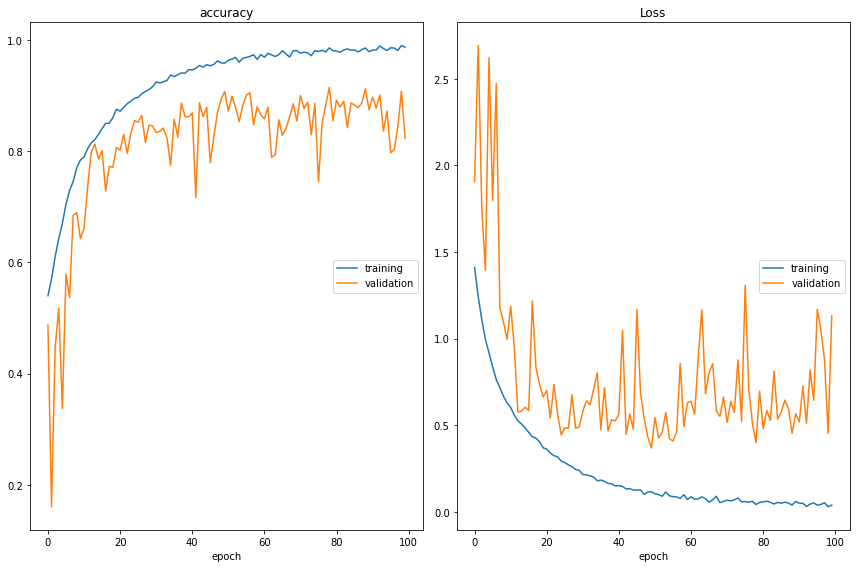

accuracy
	training         	 (min:    0.540, max:    0.990, cur:    0.987)
	validation       	 (min:    0.160, max:    0.915, cur:    0.823)
Loss
	training         	 (min:    0.029, max:    1.411, cur:    0.039)
	validation       	 (min:    0.368, max:    2.692, cur:    1.131)


In [10]:
from tensorflow.keras.layers import Input, Dense, Flatten, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from livelossplot import PlotLossesKeras

image_input = (224,224,3)
# inception = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet")

NUM_CLASSES = 9

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=image_input)
x = base_model.output

x = GlobalAveragePooling2D(name='avg_pool')(x)

outputs = Dense(NUM_CLASSES, activation='sigmoid', name='fc9')(x)

inceptionModel = Model(inputs=base_model.input, outputs=outputs)


# inceptionModel = tf.keras.Sequential(
#     [image_input,
#      inception,
#      AveragePooling2D(),
#      Dense(NUM_CLASSES, activation="softmax")])

inceptionModel.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics="accuracy")



history = inceptionModel.fit(data_train_gen,
          batch_size=batch_size,
          epochs=100,
          validation_data=data_valid_gen,
          callbacks=[PlotLossesKeras()],verbose=0
          )
          #tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1))


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


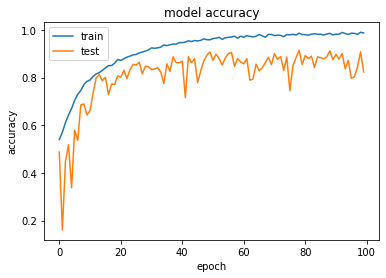

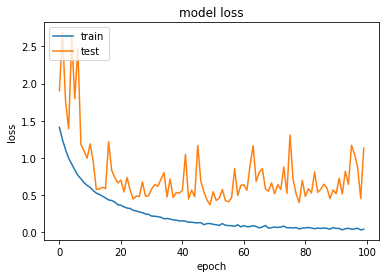

In [11]:
import matplotlib.pyplot as plt

# list all data in history**
print(history.history.keys())
# summarize history for accuracy**

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss**
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
data_valid

<PrefetchDataset shapes: {image: (256, 256, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>

In [13]:
print(inceptionModel.evaluate(data_test_gen))

219/219 [==============================] - 44s 201ms/step - loss: 1.2583 - accuracy: 0.8104
[1.2583436965942383, 0.8103940486907959]


In [14]:
inceptionModel.save("deep_weeds_inecption.h5")    

In [17]:
from tensorflow.keras.models import load_model

reconstructed_model = load_model("deep_weeds_inecption.h5")

In [ ]:
import os
export_path = os.path.join(os.getcwd(), 'deep_weeds_inception')


In [18]:
loss, accuracy = reconstructed_model.evaluate(data_test_gen)
print(f"Loss: {loss}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

219/219 [==============================] - 9s 35ms/step - loss: 1.2583 - accuracy: 0.8104
Loss: 1.2583436965942383
Test accuracy: 81.04%


In [19]:
#conveting test_data from bacthdataset to Mapdataset 
data_test = data_test.map(preprocess_weeds).batch(8)
# make prediction
y_predicted = reconstructed_model.predict(data_test_gen)

In [22]:
import numpy as np
#retrieving the labels from the test_data
ls=[]
for _,label in tfds.as_numpy(data_test):
    ls.append(label)

#data transformation
#merging the sublists of the list ls
tab_1 = [item for sublist in ls for item in sublist]

#converting numbers to binary sublists
tab_2=[]
for i in tab_1:
    a=[0]*9
    a[i]=1
    tab_2.append(a)

#converting the predictions to binary sublists
y_pred = np.argmax(y_predicted, axis=1)
y_pred[np.max(y_predicted, axis=1) < 1 / 9] = 8 

res=[]
for i in y_pred:
    l=[0]*9
    l[i]=1
    res.append(l)

res_pred=[]
for i in y_pred:
    l=[0]*9
    l[i]=1
    res_pred.append(l)

In [23]:
classe_name = ["Chinee apple", "Lantana", "Parkinsonia" ,"Parthenium", "Prickly acacia", "Rubber vine", "Siam weed","Snake weed" , "Negatives"]
classe = [0,1,2,3,4,5,6,7,8]

In [24]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(tab_2, res_pred))

Accuracy: 0.8109651627641348


In [25]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

#print("Recall:",metrics.recall_score(tab_2, res_pred),"\n")

#confusion matrix and classification report
#print("confusion matrix \n",confusion_matrix(tab_2, res_pred, labels=classe))
print("classification report \n",classification_report(tab_2, res_pred,labels = classe, target_names= classe_name))

classification report 
                 precision    recall  f1-score   support

  Chinee apple       0.63      0.60      0.62       234
       Lantana       0.74      0.83      0.78       211
   Parkinsonia       0.90      0.83      0.86       213
    Parthenium       0.71      0.46      0.56       203
Prickly acacia       0.95      0.41      0.58       217
   Rubber vine       0.67      0.84      0.75       200
     Siam weed       0.91      0.86      0.89       218
    Snake weed       0.95      0.64      0.77       235
     Negatives       0.83      0.94      0.88      1771

     micro avg       0.81      0.81      0.81      3502
     macro avg       0.81      0.71      0.74      3502
  weighted avg       0.82      0.81      0.80      3502
   samples avg       0.81      0.81      0.81      3502

